Estudiantes:

Arlex Fabian Galindez Rivera Cod: 104616010700

Adrian Felipe Gironza

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.1 MB/s eta 0:00:00


In [ ]:

import random
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from deap import base, creator, tools

In [ ]:
# Parámetros del algoritmo
num_iterations = 50
initial_temperature = 100.0
cooling_rate = 0.95

In [ ]:
def cargar_datos_asignaturas():
    # Cargar los datos de asignaturas desde un archivo JSON
    with open("asignaturas.json", encoding="latin-1") as file:
        datos = json.load(file)
    return datos

def cargar_datos_salones():
    # Cargar los datos de salones desde un archivo JSON
    with open("salones.json", encoding="utf-8-sig") as file:
        datos_sal = json.load(file)

    return datos_sal

# Definir los nombres de los días de la semana
nombres_dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]

# Definir las franjas horarias
franjas_horarias = ["7:00 - 9:00", "9:00 - 11:00", "11:00 - 13:00", "14:00 - 16:00", "16:00 - 18:00", "18:00 - 20:00"]

# Definir la cantidad de días y franjas horarias
dias = len(nombres_dias)

datos_asignaturas = cargar_datos_asignaturas()
datos_salones = cargar_datos_salones()

In [ ]:
def generar_horario_inicial(datos_asignaturas, datos_salones):
    # Crear una matriz vacía para el horario
    horario = np.empty((dias, len(franjas_horarias)), dtype=object)
    horario[:] = None

    # Obtener las asignaturas de tipo "Labor" del conjunto de datos
    asignaturas_labor = [asignatura for asignatura in datos_asignaturas if asignatura["TIPO"] in ["T", "TP","P"]]

    # Crear una lista de todas las combinaciones posibles de días y franjas horarias
    asignaturas_disponibles = [(dia, franja) for dia in range(dias) for franja in range(len(franjas_horarias))]

    # Barajar aleatoriamente las combinaciones de días y franjas horarias
    random.shuffle(asignaturas_disponibles)

    # Asignar las asignaturas a los horarios disponibles
    contador_tp = 0
    for asignatura in asignaturas_labor:
        asignada = False
        for dia, franja in asignaturas_disponibles:
            # Verificar si la casilla del horario está vacía
            if horario[dia][franja] is None:
                # Asignar un salón según el tipo de asignatura
                if asignatura["TIPO"] == "T":
                    # Asignar a un salón normal
                    salones_disponibles = [salon for salon in datos_salones["Hoja1"] if salon["TIPO"] == "SALON"]
                    salon = random.choice(salones_disponibles)
                elif asignatura["TIPO"] == "TP":
                    # Asignar a un salón de laboratorio si el contador de asignaturas "TP" en laboratorio es menor que "JR"
                    if contador_tp < asignatura["JR"]:
                        salones_disponibles = [salon for salon in datos_salones["Hoja1"] if salon["TIPO"] == "LAB"]
                        salon = random.choice(salones_disponibles)
                        contador_tp += 1
                    else:
                        # Asignar a un salón normal si ya se alcanzó el límite de asignaturas "TP" en laboratorio
                        salones_disponibles = [salon for salon in datos_salones["Hoja1"] if salon["TIPO"] == "SALON"]
                        salon = random.choice(salones_disponibles)
                else:
                    # Asignar todas las clases a salones de laboratorio
                    salones_disponibles = [salon for salon in datos_salones["Hoja1"] if salon["TIPO"] == "LAB"]
                    salon = random.choice(salones_disponibles)

                horario[dia][franja] = {
                    "asignatura": asignatura["CODIGO"],
                    "salon": salon["CODIGO"],
                    "profesor": asignatura["PROFESOR"],
                    "hora": franjas_horarias[franja]
                }
                asignada = True
                break

        # Si no se pudo asignar la asignatura, terminar el bucle
        if not asignada:
            break

    return horario

In [ ]:
def obtener_profesor(asignatura_codigo, datos_asignaturas):
    # Recorrer todas las asignaturas en los datos de asignaturas
    for asignatura in datos_asignaturas:
        # Verificar si el código de asignatura coincide
        if asignatura["CODIGO"] == asignatura_codigo:
            # Devolver el profesor de la asignatura encontrada
            return asignatura["PROFESOR"]
    # Si no se encuentra la asignatura, devolver None
    return None

In [ ]:
def calcular_fitness(horario, datos_asignaturas):
    # Crear un conjunto para almacenar las asignaturas asignadas en el horario
    asignaturas_asignadas = set()

    # Recorrer el horario y contar las asignaturas asignadas
    for dia in range(dias):
        for franja in range(len(franjas_horarias)):
            asignatura = horario[dia][franja]
            if asignatura is not None:
                asignaturas_asignadas.add(asignatura["asignatura"])

    # Calcular la aptitud como la diferencia entre el total de asignaturas de tipo "Labor" y las asignadas
    fitness = len(datos_asignaturas) - len(asignaturas_asignadas)
    return fitness

In [ ]:
def generar_vecino(horario, datos_salones):
    # Crear una copia del horario actual
    vecino = horario.copy()

    # Obtener las asignaturas asignadas en el horario actual
    asignaturas_asignadas = [(dia, franja) for dia in range(dias) for franja in range(len(franjas_horarias)) if vecino[dia][franja] is not None]

    # Barajar aleatoriamente las asignaturas asignadas
    random.shuffle(asignaturas_asignadas)

    # Intercambiar las posiciones de las asignaturas adyacentes en el horario
    for i in range(len(asignaturas_asignadas)):
        dia_actual, franja_actual = asignaturas_asignadas[i]
        nuevo_dia, nuevo_franja = asignaturas_asignadas[(i + 1) % len(asignaturas_asignadas)]
        vecino[dia_actual][franja_actual], vecino[nuevo_dia][nuevo_franja] = vecino[nuevo_dia][nuevo_franja], vecino[dia_actual][franja_actual]

    return vecino

In [ ]:
def recorrido_simulado(datos_asignaturas, datos_salones):
    # Generar un horario inicial
    horario_actual = generar_horario_inicial(datos_asignaturas, datos_salones)
    best_horario = horario_actual.copy()

    # Calcular el fitness del mejor horario actual
    best_fitness = calcular_fitness(best_horario, datos_asignaturas)

    # Inicializar la temperatura con el valor inicial
    temperature = initial_temperature

    # Realizar el recorrido simulado
    for _ in range(num_iterations):
        # Generar un vecino del horario actual
        vecino = generar_vecino(horario_actual, datos_salones)
        vecino_fitness = calcular_fitness(vecino, datos_asignaturas)

        # Actualizar el mejor horario si el vecino es mejor
        if vecino_fitness < best_fitness:
            best_horario = vecino.copy()
            best_fitness = vecino_fitness

        # Calcular la diferencia de fitness entre el vecino y el horario actual
        delta_fitness = vecino_fitness - calcular_fitness(horario_actual, datos_asignaturas)

        # Calcular la probabilidad de aceptación para el vecino
        acceptance_prob = math.exp(-delta_fitness / temperature)

        # Aceptar el vecino con cierta probabilidad
        if random.random() < acceptance_prob:
            horario_actual = vecino.copy()

        # Reducir la temperatura según la tasa de enfriamiento
        temperature *= cooling_rate

    return best_horario

In [ ]:
# Crear la clase Fitness para maximizar la aptitud
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Crear la clase Individual que representa un horario
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

In [ ]:
# Función para inicializar un individuo
def init_individual():
    return creator.Individual(toolbox.generate_horario_inicial())

In [ ]:
# Crear el objeto Toolbox
toolbox = base.Toolbox()

# Registrar las funciones necesarias en el objeto Toolbox
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("generate_horario_inicial", generar_horario_inicial, datos_asignaturas, datos_salones)
toolbox.register("evaluate", calcular_fitness, datos_asignaturas=datos_asignaturas)
toolbox.register("mutate", generar_vecino, datos_salones=datos_salones)
toolbox.register("mate", np.ndarray.copy)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
def mostrar_horario(horario, datos_asignaturas):
    # Crear una figura y un eje para el gráfico
    fig, ax = plt.subplots(figsize=(35, 20))
    ax.set_title("Horario", fontsize=20)

    # Configurar el eje y
    ax.set_ylabel("Días", fontsize=20)
    ax.set_yticks(range(dias))
    ax.set_yticklabels(nombres_dias[::-1], fontsize=15)  # Invertir el orden de los nombres de los días

    # Configurar el eje x
    ax.set_xlabel("Franjas horarias", fontsize=20)
    ax.set_xticks(range(len(franjas_horarias)))
    ax.set_xticklabels(franjas_horarias, rotation=45, ha='right', fontsize=15)

    # Crear una cuadrícula para el horario
    ax.grid(True, linestyle='-', linewidth=0.5, color='gray')

    # Mostrar el horario
    for dia in range(dias-1, -1, -1):  # Iterar en orden inverso para mostrar los días de arriba a abajo
        for franja in range(len(franjas_horarias)):
            asignatura = horario[dia][franja]
            if asignatura is not None:
                # Obtener el profesor y el nombre de la asignatura
                profesor = obtener_profesor(asignatura["asignatura"], datos_asignaturas)
                asignatura_codigo = asignatura["asignatura"]
                asignatura_nombre = "Unknown"
                salon = "Unknown"
                for info_asignatura in datos_asignaturas:
                    if info_asignatura["CODIGO"] == asignatura_codigo:
                        asignatura_nombre = info_asignatura["NOMBRE"]
                        salon = asignatura["salon"]
                        break
                # Crear el texto para mostrar en la celda del horario
                texto = f"{asignatura['hora']}\nProfesor: {profesor}\nAsignatura: {asignatura_nombre}\nSalón: {salon} "
                # Agregar el texto a la celda correspondiente en el gráfico
                ax.text(
                    franja, dias - dia - 1, texto, ha='center', va='center', fontsize=14,  # Ajustar la posición del texto
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.02')
                )

    # Mostrar una cuadrícula en blanco y negro para el horario
    ax.imshow(np.zeros((dias, len(franjas_horarias))), cmap='Greys', aspect='auto')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
def ejecutar_algoritmo_genetico(population_size, prob_mutate, num_iterations):
    # Configuración del algoritmo genético
    population = toolbox.population(n=population_size)
    best_individual = None

    # Asignar valores de aptitud a los individuos de la población inicial
    for individual in population:
        individual.fitness.values = (toolbox.evaluate(individual),)

    # Iterar a lo largo del número de iteraciones especificado
    for _ in range(num_iterations):
        # Generar descendencia mediante clonación de la población actual
        offspring = [toolbox.clone(ind) for ind in population]

        # Aplicar mutación a los hijos según la probabilidad especificada
        for child in offspring:
            if random.random() < prob_mutate:
                toolbox.mutate(child)
                child.fitness.values = (toolbox.evaluate(child),)

        # Reemplazar la población actual con la combinación de la población actual y la descendencia
        population[:] = toolbox.select(population + offspring, k=population_size)

        # Actualizar el mejor individuo de acuerdo con la aptitud
        for individual in population:
            if best_individual is None or individual.fitness > best_individual.fitness:
                best_individual = toolbox.clone(individual)

    best_horario = best_individual

    # Mostrar el horario en formato gráfico
    mostrar_horario(best_horario,datos_asignaturas)

<ipython-input-14-0ea58e9711bc>:45: UserWarning: Glyph 129 (\x81) missing from current font.
  plt.tight_layout()
<ipython-input-14-0ea58e9711bc>:45: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


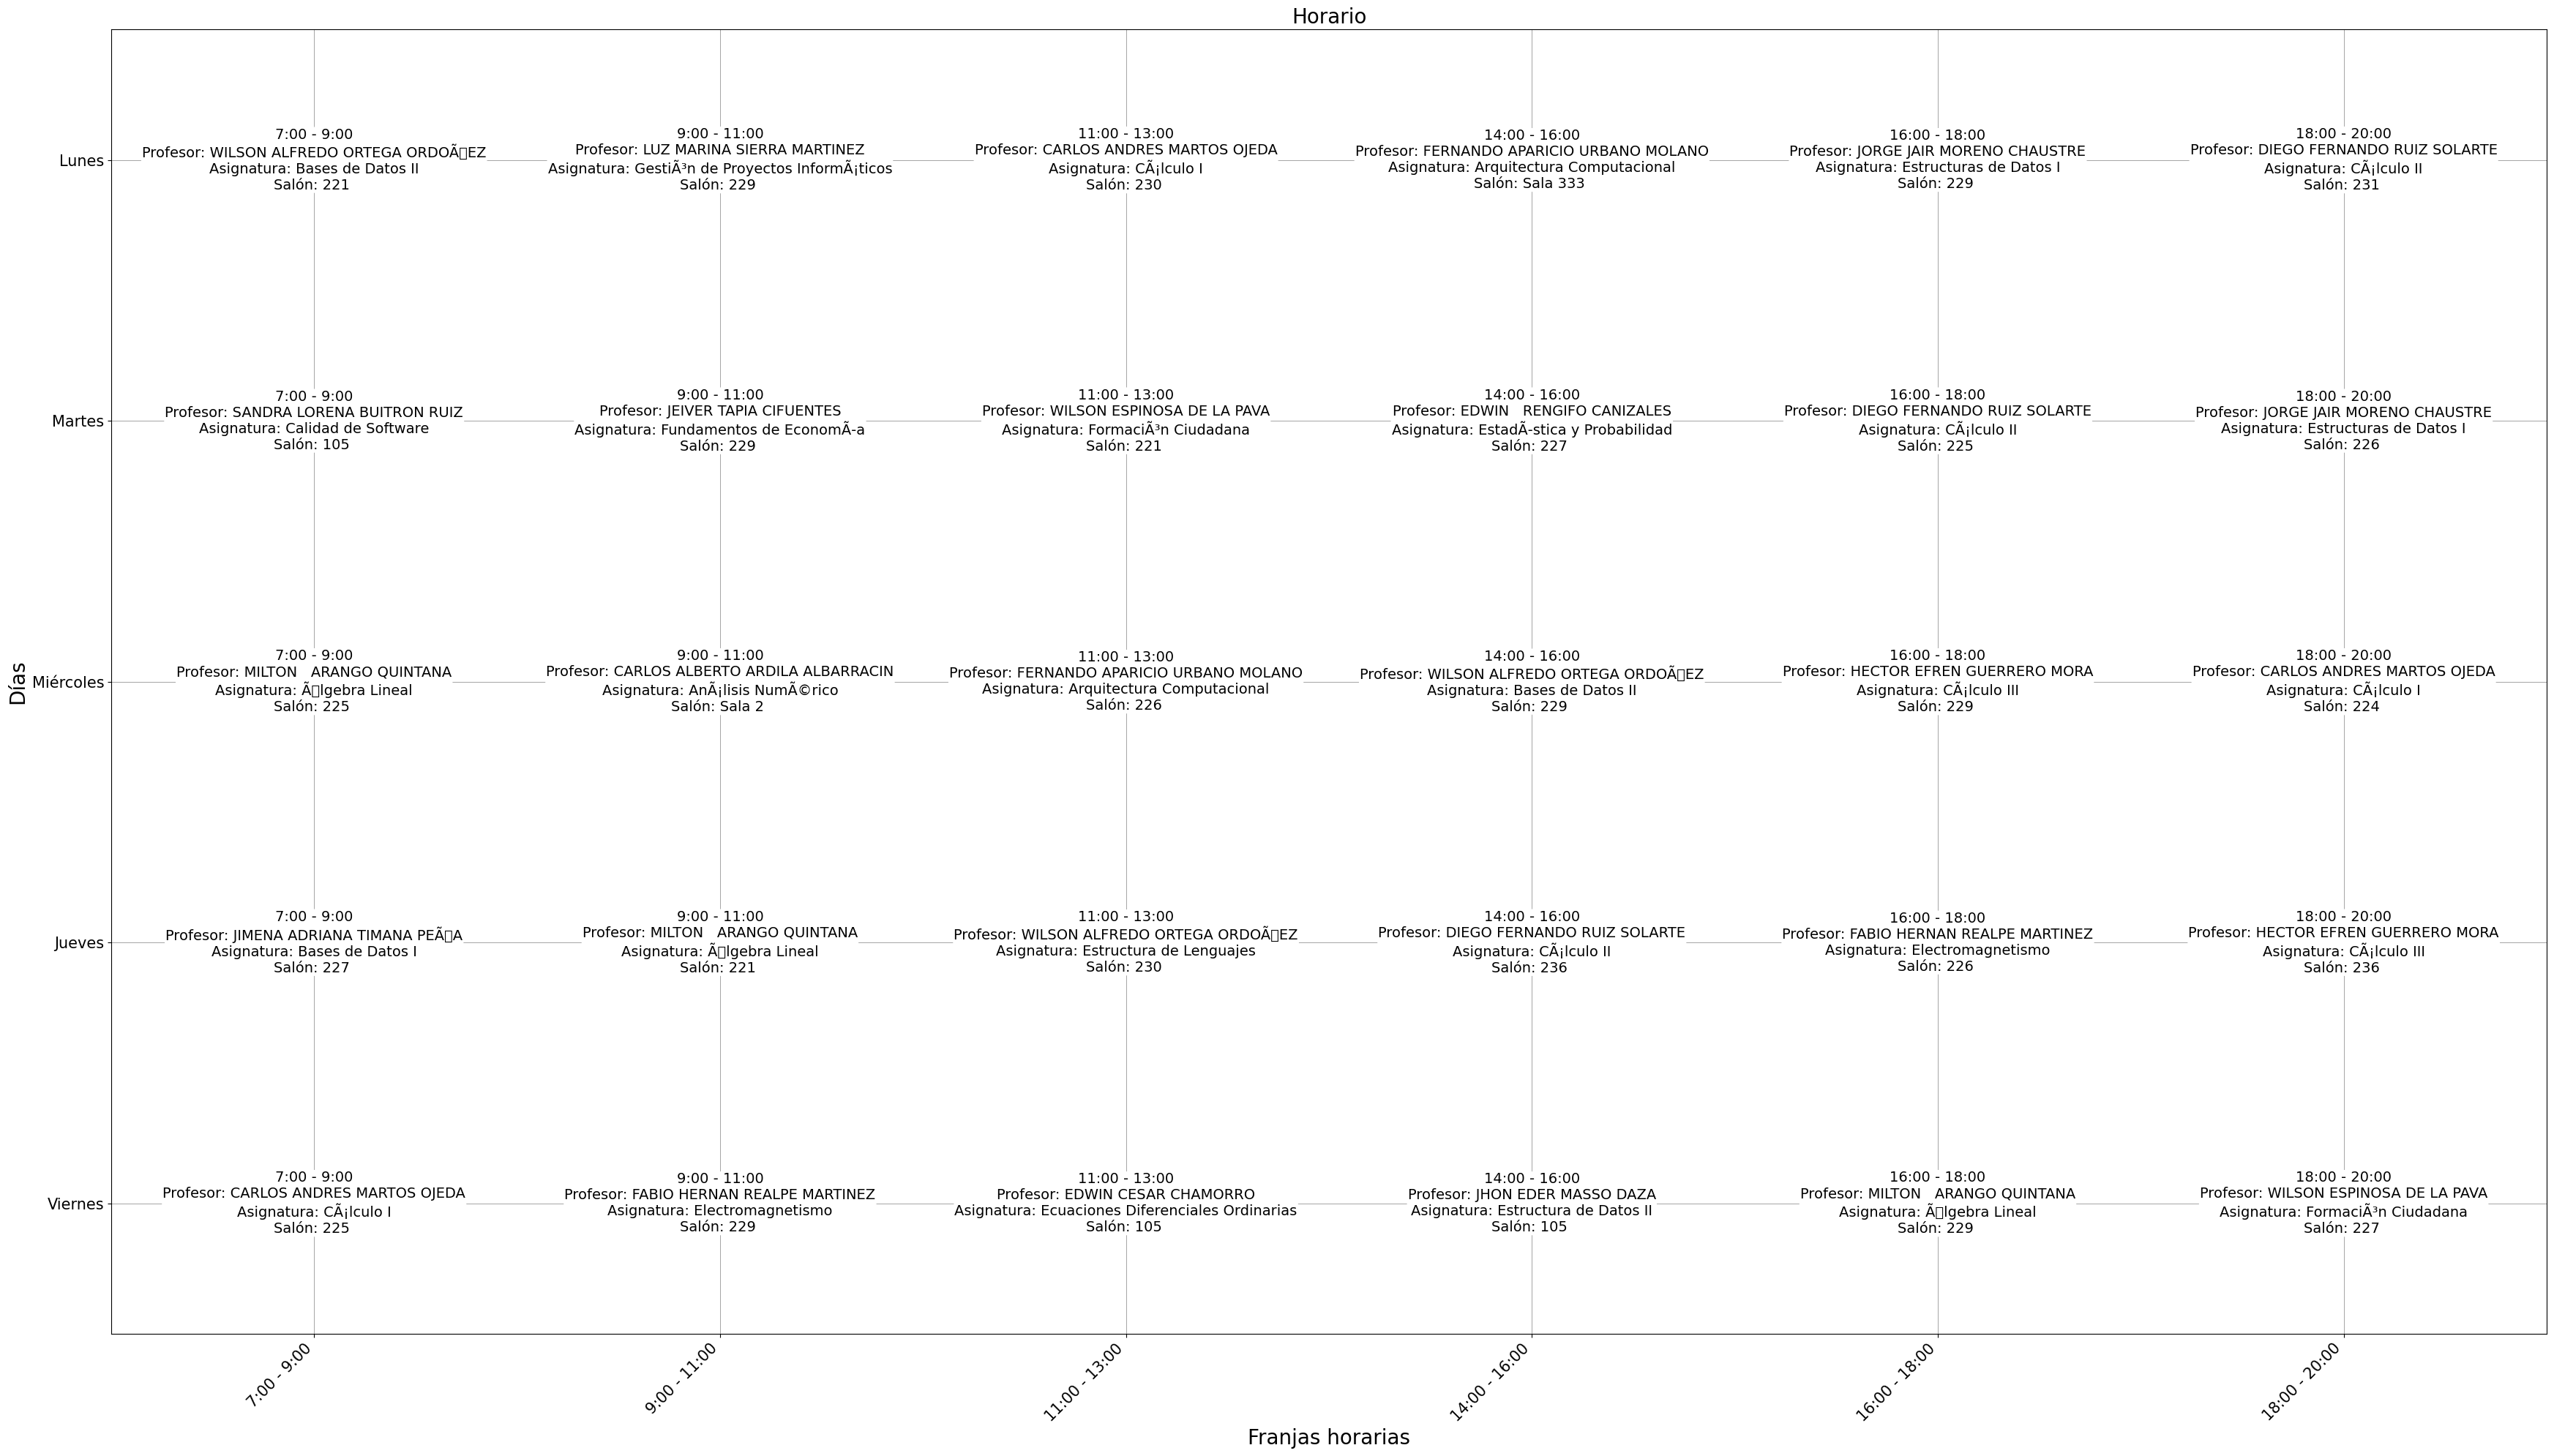

In [ ]:
population_size = 100
prob_mutate = 0.2
num_iterations = 100

ejecutar_algoritmo_genetico(population_size, prob_mutate, num_iterations)